# Autoregressive Processes: Equivalent Formulations in [TensorFlow Probability](https://www.tensorflow.org/probability/) (TFP)

There are particular hierarchical contexts in which we would like to model one or more components of the model as an autoregressive process. Conceptually, this can be a fairly straightforward exercise when defining the model, but challenges arise in implementation. When writing actual code, conformant matrix operations are a necessary but insufficient condition for success. The type transformations for the programmatic objects involved must also conform. That is, for the objects to work together in application, each object must have the attributes and behaviors that are needed for their position in the algorithm.

When using TFP, we can formulate rather complicated hierarchical models as instances of [`tfp.distributions.JointDistribution`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistribution) (or its variants). The API affords a wonderfully direct mapping of a conceptual model one might write on a piece of paper to code. The model can be directly expressed as interdependencies between a pile of distributions, arranged in a way that reflects the analyst's view of the data generating process. The challenge is that the model components must literally be subtypes of [`tfp.distributions.Distribution`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Distribution), the parent class of all distributions in the `tfd.distributions` submodule. It turns out that the most direct implementation of an autoregressive process is TFP is [`tfp.sts.AutoRegressive`](https://www.tensorflow.org/probability/api_docs/python/tfp/sts/Autoregressive), which is a subtype of [`tfp.sts.StructuralTimeSeries`](https://www.tensorflow.org/probability/api_docs/python/tfp/sts/StructuralTimeSeries). As such `AutoRegressive` does not carry the attributes and behaviors of subtypes of `Distribution`. Using it to define a component of a model via `JointDistribution` throws somewhat cryptic errors, but at the end of the day, it is not type conformant.

Fortunately, autoregressive models are special cases of more general models. In concrete TFP terms, an autoregressive process should be capable of being modeled as instances of [`tfp.sts.AutoregressiveStateSpaceModel`](https://www.tensorflow.org/probability/api_docs/python/tfp/sts/AutoregressiveStateSpaceModel) or, even more generally, [`tfp.distributions.LinearGaussianStateSpaceModel`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/LinearGaussianStateSpaceModel). Both types inherit from `Distribution` and therefore should be ok to use in defining models via `JointDistribution`. The purpose of this notebook is to demonstrate that such equivalence holds across these three different formulations.

In [12]:
import seaborn as sb
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from typing import Optional, List, Dict


%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Preliminaries 

### What is an autoregressive process?

As a reminder, an autoregressive process is one in which the observation at time $t$ is estimated based upon lagged observations $t-1$ to $t-p$. The choice of $p$ governs the "order" of autoregression in the process.

$$Y_t = Y_{t-1:t-p}'W + \epsilon$$

In the formulation above...
+ $Y_t$ is a $1 \times k$ vector of observations across series at time $t$
+ $Y_{t-1:t-p}$ is a $p \times k$ matrix of lagged values (each additional row captures the next set of lagges values)
+ $W$ is a $p \times 1$ vector of weights capturing the contribution of the values at each lag
+ $\epsilon$ is typically assumed to be an additive error normall distributed with zero mean and positive variance (i.e. $N(0, \sigma)$)

In effect, the autoregressive estimate of $y$ at time $t$ is the weighted average of the $p$ prior observations with some noise.

### How do define hierarchical models?

To set the concept of model definition, we'll start with Ordinary Least Squares (OLS) and then layer an extra relation. Recall the most common representation of the regression equation.

$$y = X\beta + \epsilon$$

In the above formulation...
+ $y$ is an $n \times 1$ vector of observations
+ $X$ is a $n \times k$ matrix of regressors
+ $\beta$ is a $k \times 1$ vector of coefficients (or weights)
+ $\epsilon$ is typically assumed to be and additive error normally distributed with zero mean and positive variance (i.e. $N(0, \sigma)$)

Given the distributional assumptions embedded in $\epsilon$, the model can be equivalently expressed as the following Bayesian system.

\begin{align}
    y &\sim N(\mu, \sigma) \\
    \mu &= X\beta \\
    \beta &\sim U(-\infty I, \infty I) \\
    \sigma &\sim N(0, 1)
\end{align}

In the above formulation, we have set completely uninformative priors for $\beta$, such that all values are equally likely. This is the implicit assumption for analytic or maximum likelihood formulations of the OLS estimator. The matrix $I$ is $k \times k$, and enables us to distribute infinite bounds across all $k$ dimensions in $\beta$. In practice, we would never really define priors this way, since we will generally be able to say things like "when considering the relationship between human height and weight, for every additional inch in height, I don't think it corresponds to a person that is a million pounds heavier on average."

When defining this model in TFP, we get a bit more explicit about the dimensionality of $X$ and $\beta$. In the situation where $k = 1$, we could have something that looks like the following.

In [5]:
n: int = 100
x_1: tf.Tensor = tf.reshape(tfd.Normal(0., 2.).sample(n), shape=(n, 1))
x_0: tf.Tensor = tf.ones(shape=(n, 1), dtype=tf.float32)
x: tf.Tensor = tf.concat([x_0, x_1], axis=1)

ols: tfd.JointDistribution = tfd.JointDistributionNamedAutoBatched(dict(
    beta=tfd.MultivariateNormalDiag(loc=[0., 5], scale_diag=[1., 3.]),
    sigma=tfd.Normal(loc=0., scale=1.),
    y_hat=lambda beta, sigma: tfd.Normal(loc=tf.matmul(x, tf.reshape(beta, shape=(2, 1))), scale=sigma)
))

In [7]:
# ols.sample(5)

Suppose we wanted to allow the weight vector $\beta$ to vary over time. Enabling variance over time would constitute the second layer in our hierarchical model. Let us rewrite the model we constructed via TFP as a conceptual model, this time with time-varying weights.

\begin{align}
    y &\sim N(\mu_t, \sigma) \\
    \mu_t &= X\beta_t \\
    \beta_t &\sim N(\theta \beta_{t-1}, \begin{bmatrix} 1 & 0 \\ 0 & 3 \end{bmatrix}) \\
    \sigma &\sim N(0, 1) \\
    \theta &\sim N(0.5, 0.2)
\end{align}

To add a layer to our hierarchy, all we had to do was make up another parameter ($\theta$) to use in our autoregressive formulation of $\beta$. The task of being able to implement this autoregressive layer in TFP is the motivating purpose of this notebook.

### What is our Data Generating Process (DGP)?

To help us evaluate whether or not we can define the same model in three different ways, let us decide on an autoregressive process that we can model and estimate. Let's keep it simple and model an AR(1) process as a proof of concept.

\begin{align}
    y_t &\sim N(\theta y_{t-1}, \sigma) \\
    \sigma &\sim N(0, 1)
\end{align}

In the above formulation, $\theta = 0.8$. We'll brute force construct it to stay out of the explicit modeling frameworks at first.

Text(0.5, 1.0, 'Brute Force')

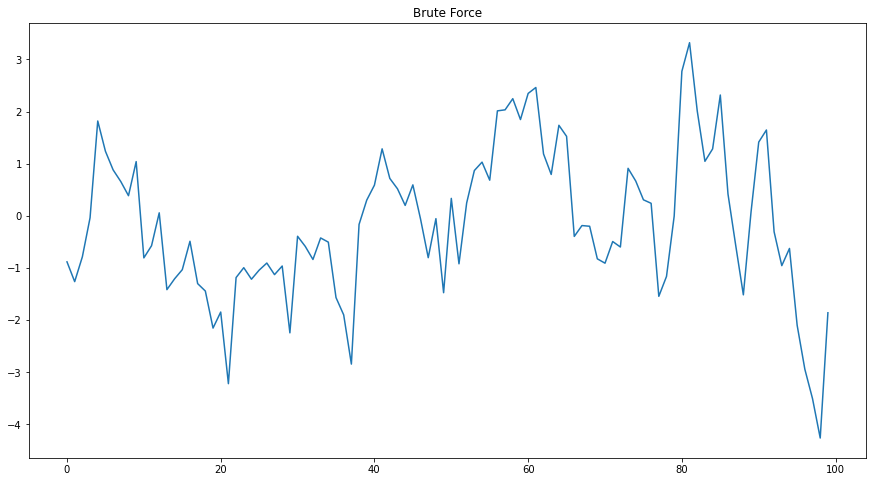

In [20]:
def ar1(theta: float, init_val: float, num_steps: int, e: tfd.Distribution = tfd.Normal(0., 1.)) -> tf.Tensor:
    out: List[float] = [init_val]
    
    for i in range(num_steps):
        next_val: float = theta * out[-1] + e.sample().numpy()
        out.append(next_val)
        
    series: tf.Tensor = tf.constant(out[1:], dtype=tf.float32)
    return series

def plot_series(y: tf.Tensor, ax_in: Optional[Axes] = None, **kwargs) -> Axes:
    if ax_in is None:
        fig: Figure
        ax: Axes
        fig, ax = plt.subplots(figsize=(15, 8))
    else:
        ax: Axes = ax_in
        
    line: Axes = sb.lineplot(x=range(y.shape[0]), y=y, ax=ax, **kwargs)
    return line

brute_force: tf.Tensor = ar1(0.8, 0., 100)
bf_plot: Axes = plot_series(brute_force)
bf_plot.set_title("Brute Force")

## Constructing AR(1) with `tfp.sts.Autoregressive`

As discussed above, the most straightforward way to generate an AR(1) process is by way of the purpose-built `Autoregressive` class. A couple items to note in construction:

+ We must specify the weights to be applied to prior observations (`coefficient_prior`). Since there can be more than one prior observation used, the distribution used to model the weights, we must use a multivariate distribution even when the process is of order 1.
+ We must specify the "innovation" (i.e. $\epsilon$) to provide variance to the process (`level_scale_prior`). There is just one value per observation so the distribution can be scalar valued.
+ We must specify the initial values (`initial_state_prior`) because how can you get lagged value $y_{t-1}$ when $t = 0$? Again, since there can be more than one lagged observation, the distribution must be multivariate.

Once we have our model, we can sample from our priors. *Note that `Autoregressive` does not have a `sample()` method like instances of `Distribution`.*

Text(0.5, 1.0, 'Sampled from AutoRegressive Model')

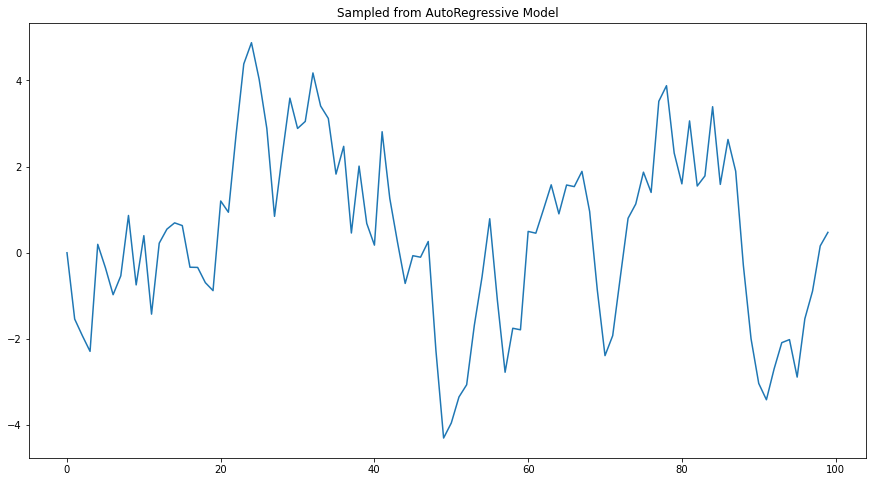

In [23]:
ar1_model: tfp.sts.Autoregressive = tfp.sts.Autoregressive(
    order=1,
    coefficients_prior=tfd.MultivariateNormalDiag(loc=0.8, scale_diag=[0.]),
    level_scale_prior=tfd.Normal(0., 1.),
    initial_state_prior=tfd.MultivariateNormalDiag(loc=0., scale_diag=[0.])
)

ar1_sample: tf.Tensor
ar1_params: List[tf.Tensor]
ar1_sample, ar1_params = ar1_model.prior_sample(100)
ar1_model_plot: Axes = plot_series(tf.reshape(ar1_sample, [-1]))
ar1_model_plot.set_title("Sampled from AutoRegressive Model")

## Constructing AR(1) with `tfp.sts.AutoregressiveStateSpaceModel`

When constructing the state space model version, curiously enough we see that the input parameters are actually deterministic rather than instances of `Distribution` (although `Distributions` can be coerced into yielding constant values when variance is zero). In general, there is a conceptual mapping between the arguments fed into `Autoregressive` and `AutoregressiveStateSpaceModel`. Note how this time we can leverage a `sample()` method, along with other attributes and behaviors that come with subtyping `Distribution`.

Text(0.5, 1.0, 'Sampled from AutoRegressiveStateSpaceModel Model')

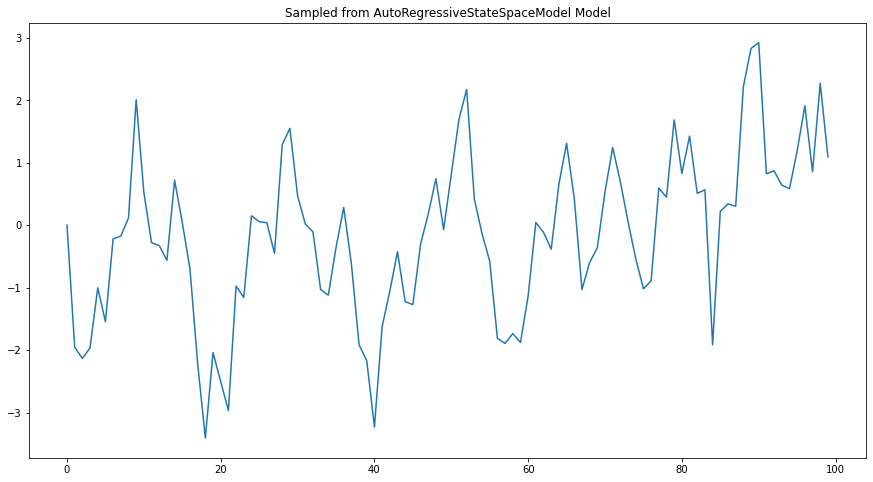

In [34]:
ar1_ssm: tfp.sts.AutoregressiveStateSpaceModel = tfp.sts.AutoregressiveStateSpaceModel(
    num_timesteps=100,
    coefficients=[0.8],
    level_scale=1.,
    initial_state_prior=tfd.MultivariateNormalDiag(loc=0., scale_diag=[0.])
)


ar1_ssm_sample: tf.Tensor = ar1_ssm.sample()
ar1_ssm_model_plot: Axes = plot_series(tf.reshape(ar1_ssm_sample, [-1]))
ar1_ssm_model_plot.set_title("Sampled from AutoRegressiveStateSpaceMode")

## Constructing AR(1) with `tfp.distributions.LinearGaussianStateSpaceModel`

As we step towards the more general linear Gaussian state space model (i.e. the form consistent with the use of the Kalman Filter), the nature of our inputs changes a bit. We are now grappling with a two-layer model. The lower layer governs the evolution of a latent state $z_t$ and upper layer governs the evolution of observed values $y_t$ which depend on the latent state $z_t$. We present here the most basic version of the idea, where the observations depend entirely on the latent state, there is only one latent level, and there are no bias terms.

\begin{align}
    y_t &\sim N(\theta z_t, \sigma) \\
    z_t &\sim N(\gamma z_{t-1}, \omega)
\end{align}

In the above formulation...

+ $y_t$ is a $t \times 1$ vector of observations
+ $\theta$ is the coefficient/weight associated with the latent state
+ $\sigma$ is normally distributed with mean zero and non-negative variance
+ $z_t$ is a $t \times 1$ vector of latent state values (we do not observe)
+ $\gamma$ is the coefficient/weight associated with the lagged state value
+ $\omega$ is normally distributed with mean zero and non-negative variance

While we have represented the coefficients as scalar values, in more general formulations they can be matrix-valued. $\theta$ is known as the *observation matrix* and $\gamma$ is known as the *transition matrix*. To generate an AR(1) process with a lagged coefficient of 0.8, one approach would be to make the observed layer pass the state cleanly through while setting the transition matrix to our desired weight. In effect, let the latent state layer do all the work.

Text(0.5, 1.0, 'Sampled from LinearGaussianStateSpaceModel')

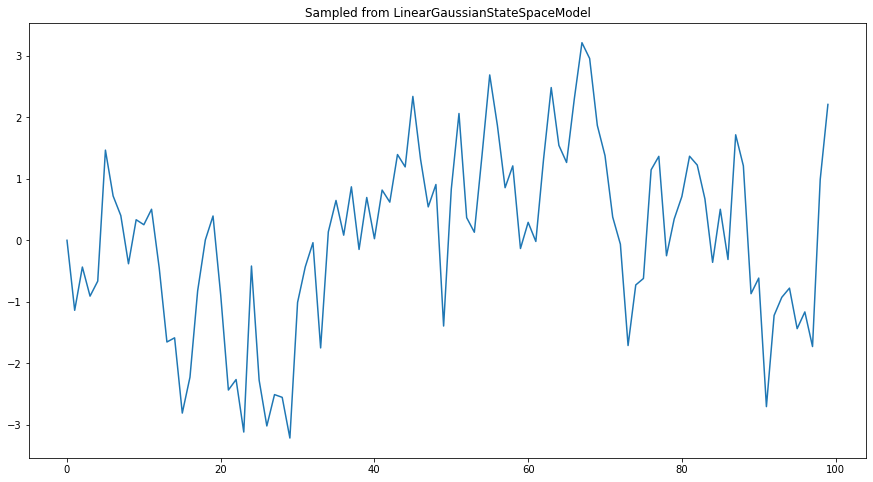

In [43]:
lgssm: tfp.distributions.LinearGaussianStateSpaceModel = tfp.distributions.LinearGaussianStateSpaceModel(
    num_timesteps=100,
    transition_matrix=tf.eye(1) * 0.8,
    transition_noise=tfd.MultivariateNormalDiag(loc=0., scale_diag=[1.]),
    observation_matrix=tf.eye(1),
    observation_noise=tfd.MultivariateNormalDiag(loc=0., scale_diag=[0.]),
    initial_state_prior=tfd.MultivariateNormalDiag(loc=0., scale_diag=[0.])
)
    
lgssm_sample: tf.Tensor = lgssm.sample()
lgssm_model_plot: Axes = plot_series(tf.reshape(lgssm_sample, [-1]))
lgssm_model_plot.set_title("Sampled from LinearGaussianStateSpaceModel")

...to be continued

In [45]:
lgssm.log_prob(brute_force[..., tf.newaxis])

<tf.Tensor: shape=(), dtype=float32, numpy=nan>